### Lib Imports

In [1]:
import time
import glob
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from io import StringIO

### Data Collection

In [2]:
def get_rookie_stats_season(year):

    def format_season(year):
        return f'{year-1}-{str(year)[2:]}'

    try:
        nba_website = requests.get(f"https://www.basketball-reference.com/leagues/NBA_{year}_rookies-season-stats.html")
        soup = BeautifulSoup(nba_website.text, 'html.parser')

        rookie_table = soup.find('table', class_='sortable stats_table')
        df_rookie = pd.read_html(StringIO(str(rookie_table)), index_col=0)[0]

        df_rookie.columns = pd.MultiIndex.from_tuples(
            [(first, f'TOT_{second}' if first == 'Totals' else second)
            for (first, second) in df_rookie.columns]
        )

        df_rookie.columns = pd.MultiIndex.from_tuples(
            [(first, f'PG_{second}' if first == 'Per Game' else second)
            for (first, second) in df_rookie.columns]
        )

        df_rookie = df_rookie.droplevel(0, axis=1)
        df_rookie.reset_index(drop=True, inplace=True)

        df_rookie['Season'] = format_season(year)
    except Exception:
        df_rookie = pd.DataFrame()

    return df_rookie


In [3]:
for year in range(1940, 2025):
    rookie_stats = get_rookie_stats_season(year)

    if rookie_stats.empty:
        print(f'No rookie stats found for year {year}')
        continue
    
    print(f'Found {rookie_stats.shape[0]} rookie stats for year {year}')
    rookie_stats.to_csv(f'../data/rookie_stats_{year}.csv', index=False)
    time.sleep(3)

No rookie stats found for year 1940
No rookie stats found for year 1941
No rookie stats found for year 1942
No rookie stats found for year 1943
No rookie stats found for year 1944
No rookie stats found for year 1945
No rookie stats found for year 1946
No rookie stats found for year 1947
No rookie stats found for year 1948
No rookie stats found for year 1949
Found 130 rookie stats for year 1950
Found 32 rookie stats for year 1951
Found 31 rookie stats for year 1952
Found 36 rookie stats for year 1953
Found 37 rookie stats for year 1954
Found 37 rookie stats for year 1955
Found 31 rookie stats for year 1956
Found 28 rookie stats for year 1957
Found 23 rookie stats for year 1958
Found 27 rookie stats for year 1959
Found 19 rookie stats for year 1960
Found 20 rookie stats for year 1961
Found 38 rookie stats for year 1962
Found 38 rookie stats for year 1963
Found 25 rookie stats for year 1964
Found 27 rookie stats for year 1965
Found 25 rookie stats for year 1966
Found 34 rookie stats for y

In [4]:
df_rookie_stats = pd.concat([pd.read_csv(f) for f in glob.glob('../data/rookie_stats_*.csv')], ignore_index=True)
df_rookie_stats.head()

,Player,Debut,Age,Yrs,TOT_G,TOT_MP,TOT_FG,TOT_FGA,TOT_3P,TOT_3PA,...,FG%,3P%,FT%,PG_MP,PG_PTS,PG_TRB,PG_AST,PG_STL,PG_BLK,Season
0,Cliff Barker,"Nov 1, '49, INO vs. DNN",29,1,49,NaN,102,274,NaN,NaN,...,.372,NaN,.708,NaN,5.7,NaN,2.2,NaN,NaN,1949-50
1,Leo Barnhorst,"Nov 1, '49, CHS vs. NYK",25,1,67,NaN,174,499,NaN,NaN,...,.349,NaN,.698,NaN,6.5,NaN,2.1,NaN,NaN,1949-50
2,Ed Bartels,"Oct 29, '49, DNN @ TRI",24,1,15,NaN,22,86,NaN,NaN,...,.256,NaN,.559,NaN,4.2,NaN,1.3,NaN,NaN,1949-50
3,Ralph Beard,"Nov 1, '49, INO vs. DNN",22,1,60,NaN,340,936,NaN,NaN,...,.363,NaN,.762,NaN,14.9,NaN,3.9,NaN,NaN,1949-50
4,Gene Berce,"Oct 29, '49, TRI vs. DNN",23,1,3,NaN,5,16,NaN,NaN,...,.313,NaN,.000,NaN,3.3,NaN,0.7,NaN,NaN,1949-50


### Data Prep

In [5]:
df_rookie_stats.columns

Index(['Player', 'Debut', 'Age', 'Yrs', 'TOT_G', 'TOT_MP', 'TOT_FG', 'TOT_FGA',
       'TOT_3P', 'TOT_3PA', 'TOT_FT', 'TOT_FTA', 'TOT_ORB', 'TOT_TRB',
       'TOT_AST', 'TOT_STL', 'TOT_BLK', 'TOT_TOV', 'TOT_PF', 'TOT_PTS', 'FG%',
       '3P%', 'FT%', 'PG_MP', 'PG_PTS', 'PG_TRB', 'PG_AST', 'PG_STL', 'PG_BLK',
       'Season'],
      dtype='object')

In [6]:
df_rookie_stats.drop(columns=['Debut', 'Yrs', 'TOT_G', 'TOT_MP', 'TOT_FG', 'TOT_FGA', 'TOT_3P', 'TOT_3PA', 'TOT_FT', 'TOT_FTA', 'TOT_ORB', 'TOT_TRB', 'TOT_AST', 'TOT_STL', 'TOT_BLK', 'TOT_TOV', 'TOT_PF', 'TOT_PTS'], inplace=True)
df_rookie_stats.columns = df_rookie_stats.columns.str.replace('%', '_PCT')
df_rookie_stats.columns

Index(['Player', 'Age', 'FG_PCT', '3P_PCT', 'FT_PCT', 'PG_MP', 'PG_PTS',
       'PG_TRB', 'PG_AST', 'PG_STL', 'PG_BLK', 'Season'],
      dtype='object')

In [7]:
df_rookie_stats.dropna(subset=['Player'], inplace=True)
df_rookie_stats = df_rookie_stats[(df_rookie_stats['Player'] != 'Player')]
df_rookie_stats['Player'] = df_rookie_stats['Player'].str.replace('*', '')
df_rookie_stats = df_rookie_stats.reset_index(drop=True)

In [8]:
df_rookie_stats.fillna(0, inplace=True)

In [9]:
features = df_rookie_stats.columns[1:-1]

for feature in features:
    df_rookie_stats[feature] = pd.to_numeric(df_rookie_stats[feature])

df_rookie_stats['Season'] = df_rookie_stats['Season'].astype('category')
df_rookie_stats['Player'] = df_rookie_stats['Player'].astype(str).str.strip()

df_rookie_stats.dtypes

Player      object
Age          int64
FG_PCT     float64
3P_PCT     float64
FT_PCT     float64
PG_MP      float64
PG_PTS     float64
PG_TRB     float64
PG_AST     float64
PG_STL     float64
PG_BLK     float64
Season    category
dtype: object

In [10]:
roy_winners_website = requests.get("https://www.basketball-reference.com/awards/roy.html")
soup = BeautifulSoup(roy_winners_website.text, 'html.parser')

roy_winners_table = soup.find('table', id='roy_NBA')
df_roy_winners_table = pd.read_html(StringIO(str(roy_winners_table)))[0]
df_roy_winners_table = df_roy_winners_table.droplevel(0, axis=1)
df_roy_winners_table['ROY'] = 1

df_roy_winners_table.to_csv('../data/roy_winners.csv', index=False)

In [11]:
roy_winners = pd.read_csv('../data/roy_winners.csv')

roy_winners = roy_winners[roy_winners['Lg'].str.strip() == 'NBA']
roy_winners = roy_winners[['Player', 'Season', 'ROY']]

roy_winners.head()

,Player,Season,ROY
0,Victor Wembanyama,2023-24,1
1,Paolo Banchero,2022-23,1
2,Scottie Barnes,2021-22,1
3,LaMelo Ball,2020-21,1
4,Ja Morant,2019-20,1


In [12]:
roy_winners['Player'] = roy_winners['Player'].str.replace('*', '')
roy_winners['Player'] = roy_winners['Player'].str.replace('(Tie)', '')
roy_winners['Player'] = roy_winners["Player"].str.strip()

In [13]:
df_rookie_stats_roy = df_rookie_stats.merge(
    roy_winners,
    on=['Player', 'Season'],
    how='left'
)

df_rookie_stats_roy['ROY'] = df_rookie_stats_roy['ROY'].fillna(0)
df_rookie_stats_roy['ROY'] = df_rookie_stats_roy['ROY'].astype(int)

C:\Users\Pichau\AppData\Local\Temp\ipykernel_21488\2233250384.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_rookie_stats.groupby('Season').size().plot(kind='bar')


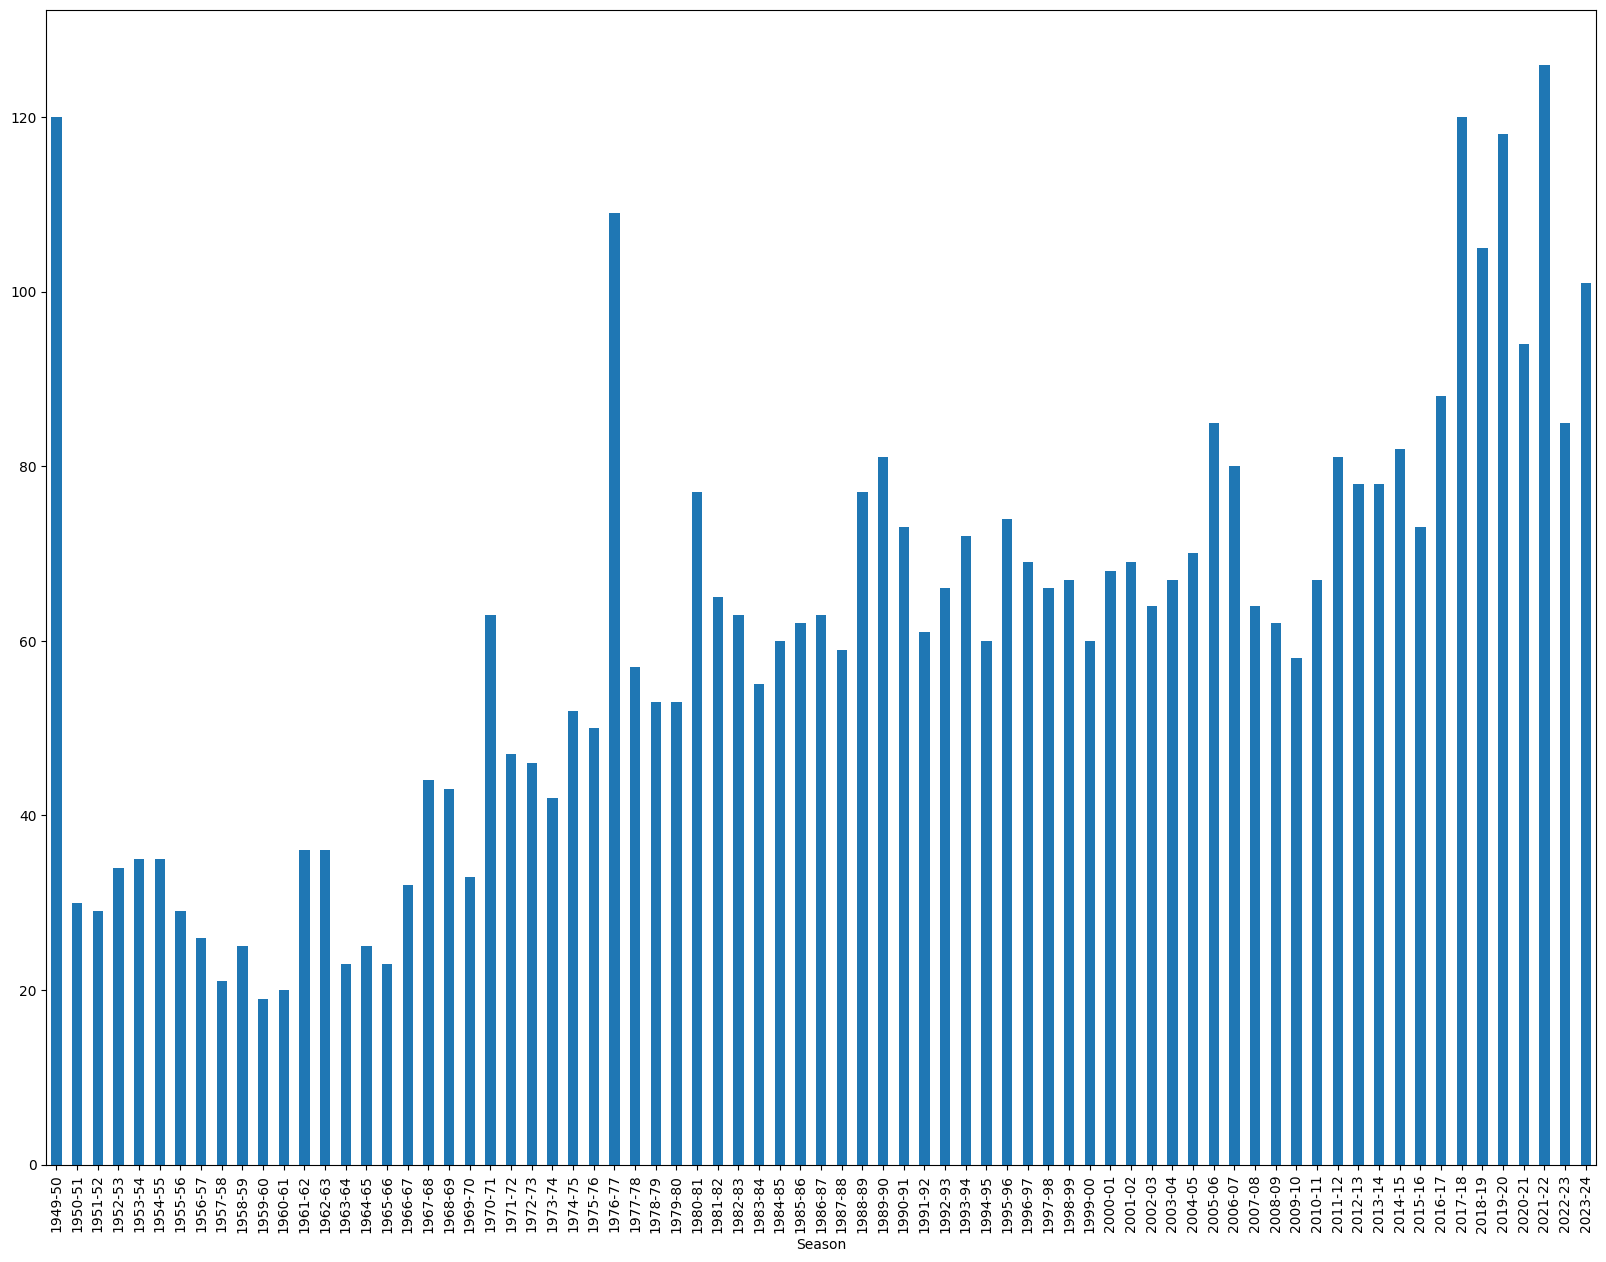

In [14]:
# plot number of rookies per season
plt.figure(figsize=(20, 15))
df_rookie_stats.groupby('Season').size().plot(kind='bar')
plt.show()

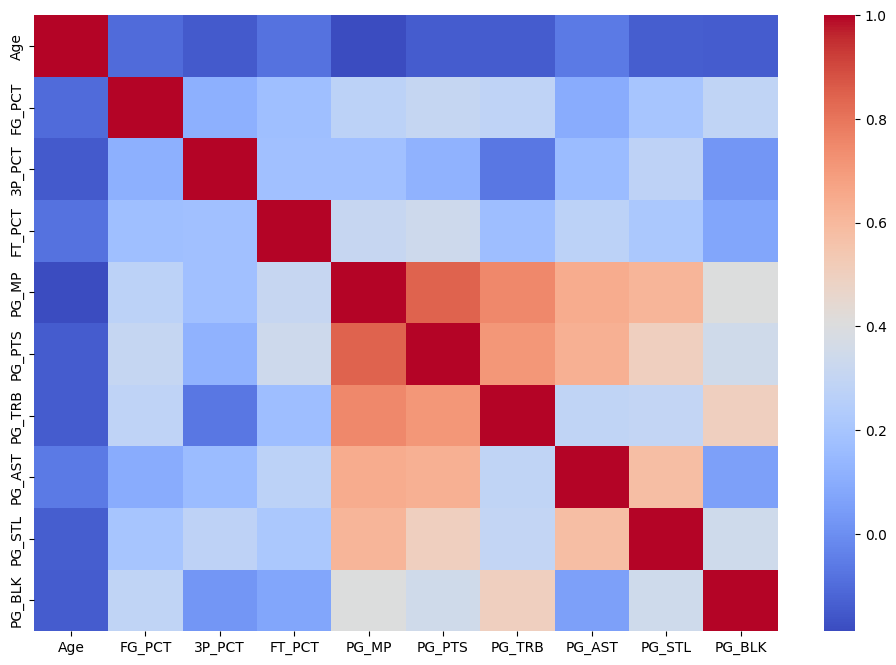

In [15]:
plt.figure(figsize=(12, 8))

df_features = df_rookie_stats_roy.drop(columns=['Player', 'Season', 'ROY'])

sns.heatmap(df_features.corr(), fmt='.2f', cmap='coolwarm')
plt.show(sns)

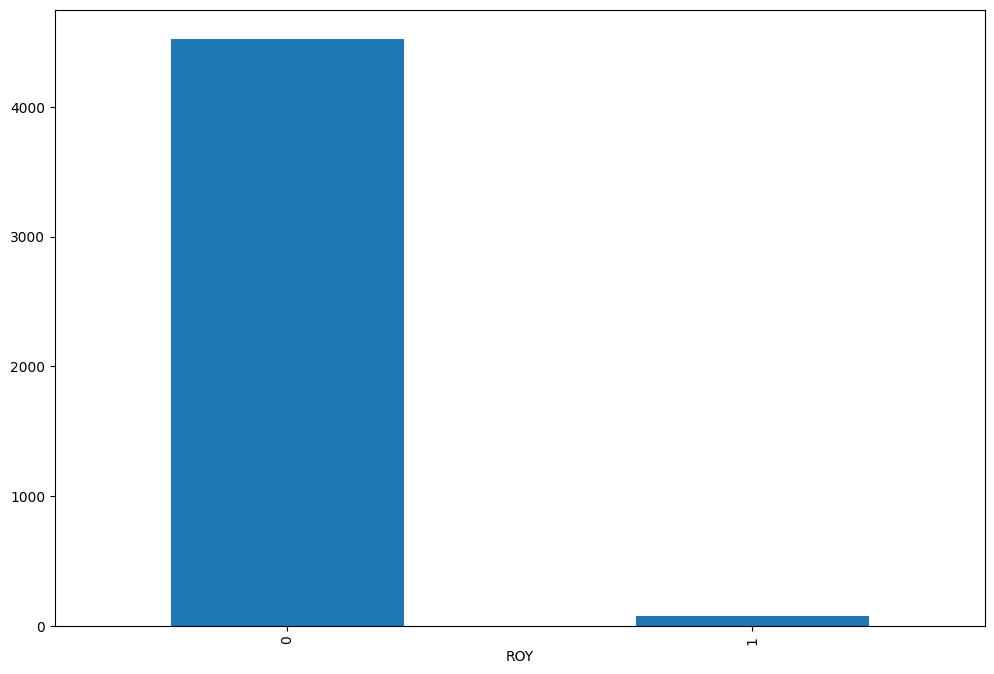

In [16]:
# plot number of ROY winners per season
plt.figure(figsize=(12, 8))
df_rookie_stats_roy.groupby('ROY').size().plot(kind='bar')
plt.show()

In [17]:
# apply smote to balance the dataset
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X = df_rookie_stats_roy.drop(columns=['Player', 'Season', 'ROY'])
y = df_rookie_stats_roy['ROY']

X_smote, y_smote = smote.fit_resample(X, y)

df_rookie_stats_roy_smote = pd.concat([X_smote, y_smote], axis=1)

,Age,FG_PCT,3P_PCT,FT_PCT,PG_MP,PG_PTS,PG_TRB,PG_AST,PG_STL,PG_BLK,ROY
0,29,0.372,0.0,0.708,0.0,5.7,0.0,2.2,0.0,0.0,0
1,25,0.349,0.0,0.698,0.0,6.5,0.0,2.1,0.0,0.0,0
2,24,0.256,0.0,0.559,0.0,4.2,0.0,1.3,0.0,0.0,0
3,22,0.363,0.0,0.762,0.0,14.9,0.0,3.9,0.0,0.0,0
4,23,0.313,0.0,0.000,0.0,3.3,0.0,0.7,0.0,0.0,0


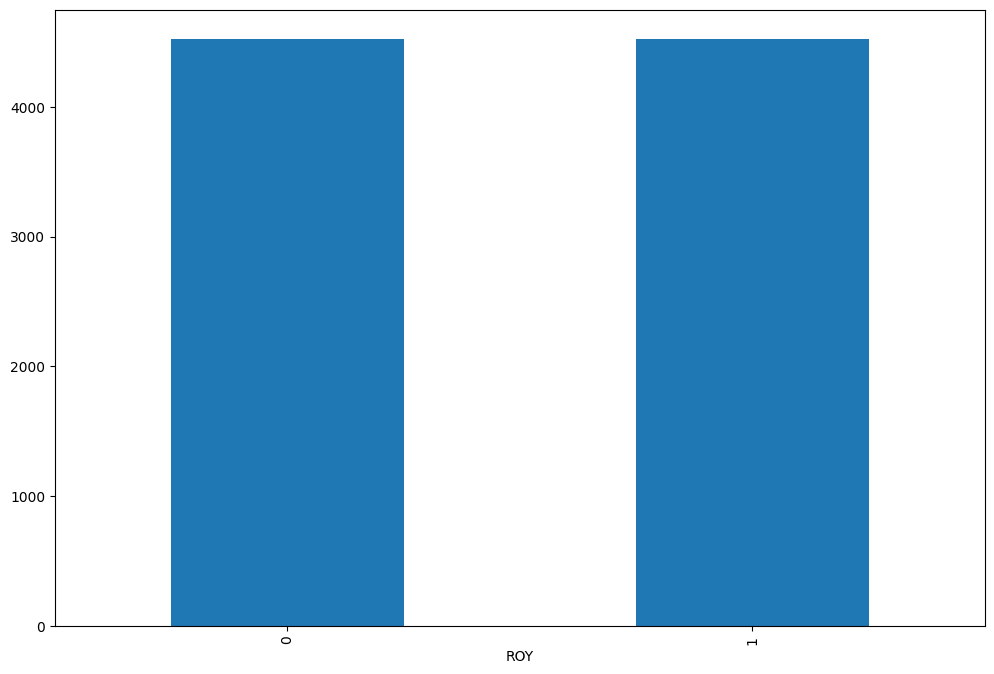

In [18]:
# plot number of ROY winners per season
plt.figure(figsize=(12, 8))
df_rookie_stats_roy_smote.groupby('ROY').size().plot(kind='bar')
plt.show()

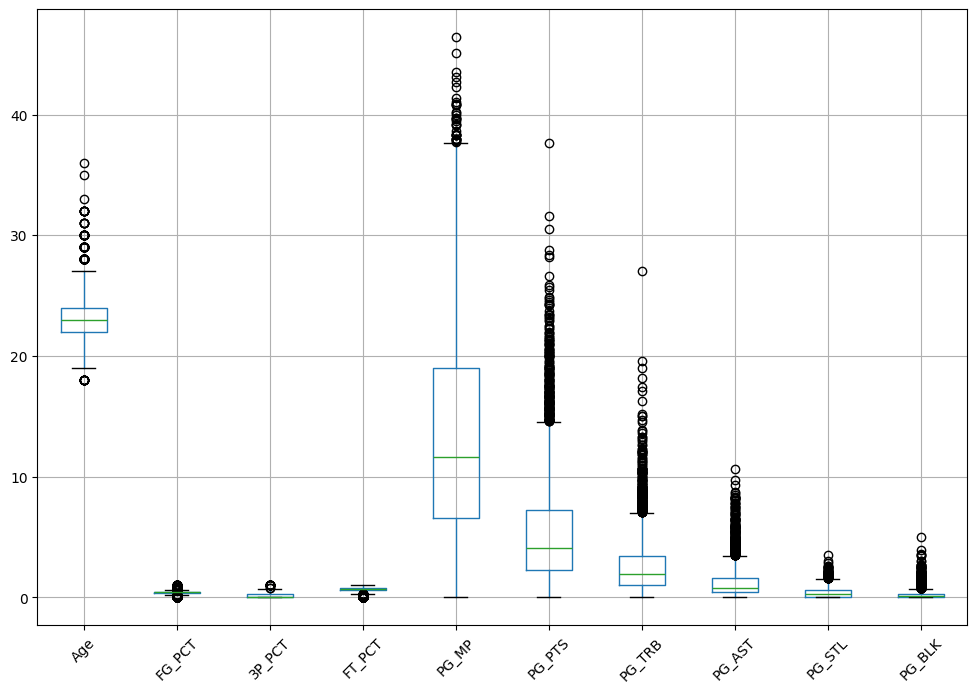

In [19]:
# plot boxplot of features
plt.figure(figsize=(12, 8))
X.boxplot()
plt.xticks(rotation=45)
plt.show()

In [20]:
# Feature scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_features_scaled = scaler.fit_transform(X_smote)

df_features_scaled = pd.DataFrame(df_features_scaled, columns=df_rookie_stats_roy.drop(columns=['Player', 'Season', 'ROY']).columns)

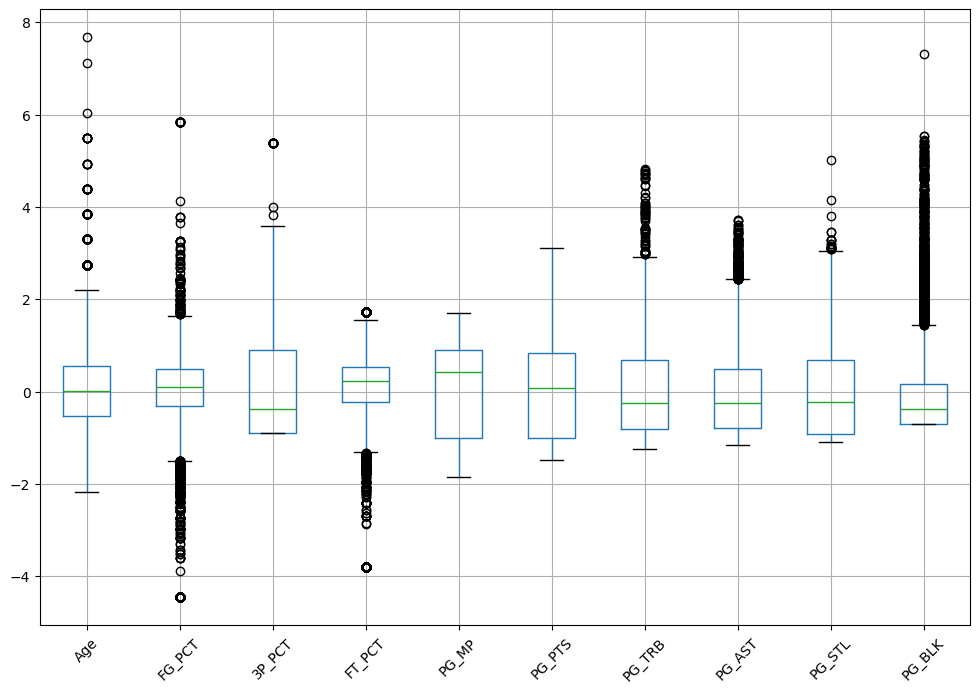

In [21]:
# plot boxplot of features
plt.figure(figsize=(12, 8))
df_features_scaled.boxplot()
plt.xticks(rotation=45)
plt.show()

In [22]:
# Train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_features_scaled, y_smote, test_size=0.2, random_state=42)

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

hparameters = {
    'n_neighbors': range(1,11),
    'metric': ['euclidean', 'cityblock', 'cosine', 'manhattan', 'minkowski'],
    'weights':['uniform', 'distance']
}

model = KNeighborsClassifier()

best_model = GridSearchCV(
    model, 
    hparameters,
    cv = 10,
    scoring = 'accuracy',
    n_jobs = -1
)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print('Best parameters:', best_model.best_params_)
print('Accuracy:', accuracy_score(y_pred, y_test))

Best parameters: {'metric': 'cosine', 'n_neighbors': 2, 'weights': 'uniform'}
Accuracy: 0.981767955801105


In [24]:
from sklearn.linear_model import LogisticRegression

hparameters = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty': ['none', 'l1', 'l2', 'elasticnet'],
    'C': np.logspace(-3,3,7)
}

model = LogisticRegression()

best_model = GridSearchCV(
    model,
    hparameters,
    cv = 10,
    scoring = 'accuracy',
    n_jobs = -1
)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print('Best parameters:', best_model.best_params_)
print('Accuracy:', accuracy_score(y_pred, y_test))

Best parameters: {'C': 100.0, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy: 0.9602209944751381


e:\Users\windows\Documents\Projects\nba-roy-prediction\venv\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
560 fits failed out of a total of 840.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
78 fits failed with the following error:
Traceback (most recent call last):
  File "e:\Users\windows\Documents\Projects\nba-roy-prediction\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "e:\Users\windows\Documents\Projects\nba-roy-prediction\venv\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "e:\Users\windows\Documents\Projects\nba-roy-prediction\venv\Lib\site-pa

In [25]:
from sklearn.ensemble import RandomForestClassifier

hparameters = { 
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

model = RandomForestClassifier()

best_model = GridSearchCV(
    model,
    hparameters,
    cv = 10,
    scoring = 'accuracy',
    n_jobs = -1
)

best_model.fit(X_train,y_train)
y_pred = best_model.predict(X_test) 

print('Best parameters:', best_model.best_params_)
print('Accuracy:', accuracy_score(y_pred, y_test))

Best parameters: {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 200}
Accuracy: 0.9861878453038674


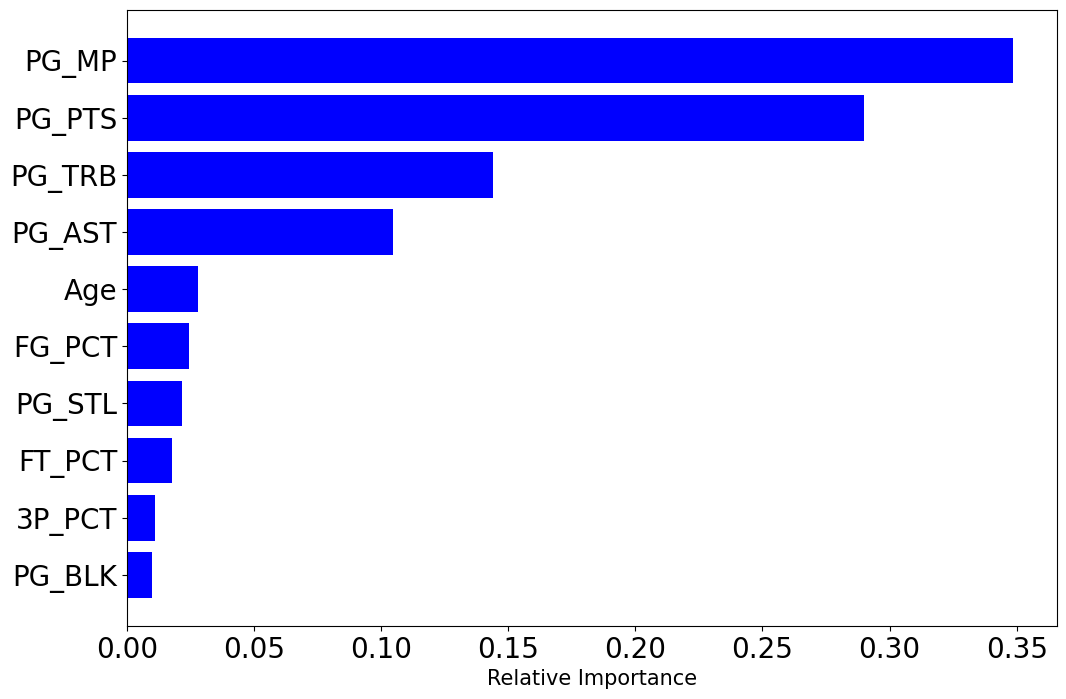

In [26]:
features_names = df_features_scaled.columns

importances = best_model.best_estimator_.feature_importances_
indices = np.argsort(importances)
lmeas_order = []

for i in indices:
    lmeas_order.append(features_names[i])

plt.figure(figsize=(12, 8))
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), lmeas_order, fontsize=15)
plt.xlabel('Relative Importance',fontsize=15)
plt.xticks(color='k', size=20)
plt.yticks(color='k', size=20)
plt.show()